In [1]:
import numpy as np
import pandas as pd
import os
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from scipy.special import iv
from scipy.optimize import curve_fit

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

deriv_dir = os.path.expanduser("../derivatives")
dataframes_dir = os.path.join(deriv_dir, "dataframes")

subjects = [114, 115, 127, 135, 136, 139, 141, 142]
rois = ['V1', 'V2', 'V3', 'V4', 'LO1', 'V3ab', 'IPS0']
tasks = ['perception', 'wm', 'ltm']

task_cmap = {
    'perception': 'darkblue',
    'wm': 'green',
    'ltm': 'orange'
}
roi_label_loc = {roi:rois.index(roi) for roi in rois}

scatter_dot_size = 4
fig_height = 5
fig_width = 5

rois = ["V1", 'V2', 'V3', 'V4', 'LO1', 'V3ab', 'IPS0']
tasks = ['perception', 'wm', 'ltm']
metrics = ['loc_deg', 'amp', 'fwhm']

# dataframe_dir = os.path.expanduser("~/mnt/winawer/Projects/Woodry_2024/derivatives/dataframes")

# Logistic Functions
def logistic(x, l, k, x0, c):
    y = l * (1 / (1 + np.exp(-k * (x - x0)))) + np.log(c)
    return y


def logistic2(x, l, k, x0, c, k2, x2, c2):
    y1 = l * (1 / (1 + np.exp(-k * (x - x0)))) + np.log(c)
    y2 = l * (1 / (1 + np.exp(-k2 * (x - x2)))) + np.log(c2)

    y = y1 * y2

    return y


plt.style.use('seaborn-v0_8')

# Figure 6a

In [2]:
data_pattern = os.path.join(dataframes_dir, "p-ltm-wm-cue-sacc-wmtarget/sub-wlsubj%03d/timeseries/denoiseddata_TTA_run-%02d.tsv")
pred_pattern = os.path.join(dataframes_dir, "p-ltm-wm-cue-sacc-wmtarget/sub-wlsubj%03d/timeseries/pred_all_TTA_run-%02d.tsv")

TTA_data = []
TTA_pred = []

for subj, run in itertools.product(subjects, range(12)):
    # load denoised data trial-triggered averages
    fname = data_pattern % (subj, run+1)
    data = pd.read_csv(fname, sep = '\t', index_col = 0)
    TTA_data.append(data)

    # load 66-model predicted trial-triggered averages
    fname = pred_pattern % (subj, run+1)
    pred = pd.read_csv(fname, sep = '\t', index_col = 0)
    TTA_pred.append(pred)

TTA_data = pd.concat(TTA_data)
TTA_pred = pd.concat(TTA_pred)

TTA_data = TTA_data.groupby(['roi_labels', 'ang_dist_bin', 'task'], as_index = False).mean()
TTA_pred = TTA_pred.groupby(['roi_labels', 'ang_dist_bin', 'task'], as_index = False).mean()



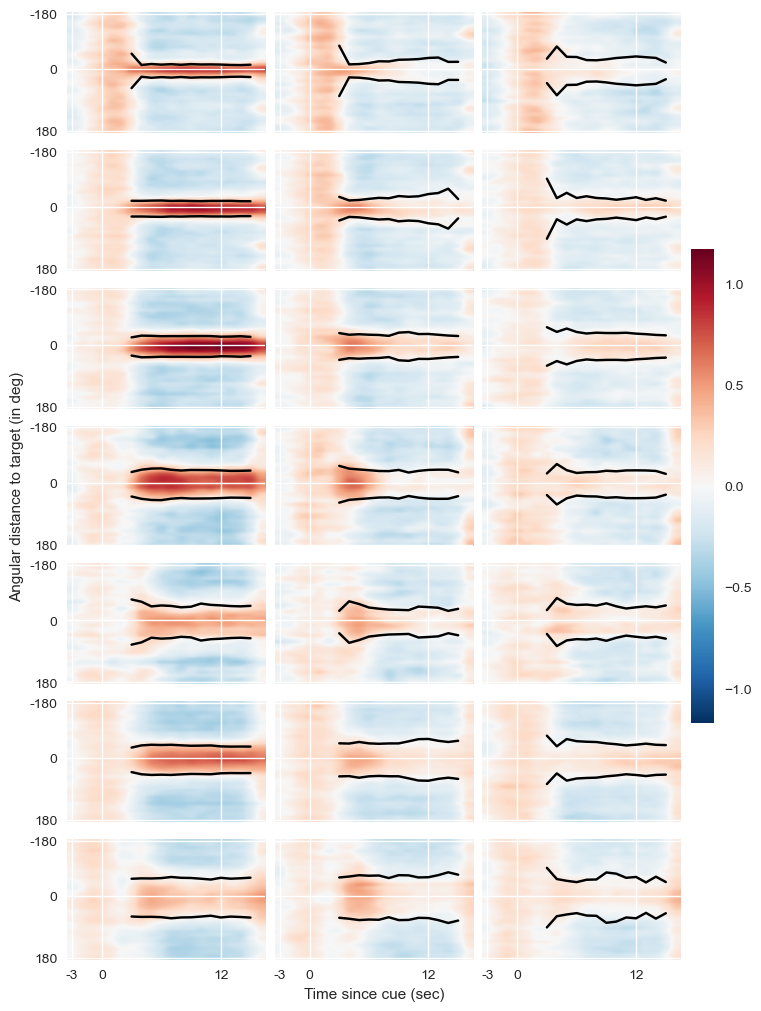

In [3]:
# Load data
data_fname = os.path.join(dataframes_dir, "p-ltm-wm-cue-sacc-wmtarget/tta_vmfits_denoiseddata.tsv")
pred_fname = os.path.join(dataframes_dir, "p-ltm-wm-cue-sacc-wmtarget/tta_vmfits_pred_all.tsv")

tta_vmf_data = pd.read_csv(data_fname, sep = '\t', index_col = 0)
tta_vmf_pred = pd.read_csv(pred_fname, sep = '\t', index_col = 0)

tta_vmf_data.insert(0, 'component', 'denoiseddata')
tta_vmf_pred.insert(0, 'component', 'pred_all')

data_fname = os.path.join(dataframes_dir, "p-ltm-wm-cue-sacc-wmtarget/tta_logfits_denoiseddata.tsv")
pred_fname = os.path.join(dataframes_dir, "p-ltm-wm-cue-sacc-wmtarget/tta_logfits_pred_all.tsv")

tta_log_data = pd.read_csv(data_fname, sep = '\t', index_col = 0)
tta_log_pred = pd.read_csv(pred_fname, sep = '\t', index_col = 0)

log_params = pd.concat([tta_log_data, tta_log_pred])
vmfits = pd.concat([tta_vmf_data, tta_vmf_pred])

fig, axs = plt.subplots(7, 3, sharex = True, sharey = True, figsize = [fig_width * 1.5, fig_height*2], layout = 'constrained')

vm_dict = {}
for task in tasks:
    tta = np.asarray(TTA_data.query("task == @task").filter([str(i) for i in range(-30, 30)]))
    vm_dict[task] = np.abs(np.asarray([tta.min(), tta.max()])).max()

for roi, task in itertools.product(rois, tasks):
    r, c = rois.index(roi), tasks.index(task)
    ax = axs[r, c]

    tta = np.asarray(TTA_data.query("roi_labels == @roi & task == @task").filter([str(i) for i in range(-30, 30)]))
    vm = vm_dict['perception']

    im = ax.imshow(tta, aspect = 'auto', interpolation = 'gaussian', cmap = 'RdBu_r', vmin = -vm, vmax = vm)
    ax.set_yticks([0, 16.5, 35], [-180, 0, 180])
    ax.set_xticks([0, 3, 15], [-3, 0, 12])

    fwhm = vmfits.query("roi_labels == @roi & task == @task & component == 'denoiseddata'").fwhm.values[6:-1] 
    x = np.arange(6, 19)
    ax_fwhm = ax.twinx()
    ax_fwhm.plot(x, fwhm/2 - 5, color = 'black') # Shift by 5 so centerline lines up with image
    ax_fwhm.plot(x, -fwhm/2 - 5, color = 'black')
    ax_fwhm.set_ylim([180, -180])
    ax_fwhm.set_yticks([])

    if r == 6: 
        if task == 'wm':
            ax.set_xlabel('Time since cue (sec)')

    if c == 0 and r == 3:
        ax.set_ylabel('Angular distance to target (in deg)')

# fig.tight_layout()
fig.colorbar(im, ax=axs[:, -1], shrink = 0.5)

plt.savefig(os.path.join("fig_images", "fig6A.pdf") , transparent = False)

# Figure 6b

In [4]:
path_pattern = "../derivatives/dataframes/p-ltm-wm-cue-sacc-wmtarget/bootstrap_logfits/tta_logfits_batch_%d.tsv"

boots = []
for i in range(1, 101):
    fname = path_pattern % i
    data = pd.read_csv(fname, sep = '\t', index_col = 0)
    data.insert(0, 'batch_num', i)
    boots.append(data)

boots = pd.concat(boots)
boots['roi'] = pd.Categorical(boots['roi'], categories = rois , ordered = True)
boots["roi_code"] = boots.roi.cat.codes.values
boots['n_boot'] = boots.n_boot + 100*(boots.batch_num-1)

The section of code below will take longer to run. On my desktop it takes a few minutes.

In [5]:
log_params = log_params.query("component == 'denoiseddata'")
start, stop = 0, -2
t = np.linspace(vmfits.timepoint.unique()[0], vmfits.timepoint.unique()[-2], 10000)

conf_interval = [16, 84]

# Error bands 
EB = {}

# For each roi x condition, generate the logistic curve and its confidence interval
for i, row in log_params.iterrows():

    # Get bootstrap intervals
    bfits = []
    b = boots.query('task == @row.task & roi == @row.roi').filter(['roi', 'task', 'l', 'k', 'x0', 'c', 'k2', 'x2', 'c2'])
    for j, brow in b.iterrows():
        match row.task:
            case 'wm':
                params = [brow.l, brow.k, brow.x0, brow.c, brow.k2, brow.x2, brow.c2]
                yhat = logistic2(t, *params)
            case 'perception' | 'ltm':
                params = [brow.l, brow.k, brow.x0, brow.c]
                yhat = logistic(t, *params)

        
        bfits.append(yhat)
    bfits=np.vstack(bfits)
    err_bands = np.nanpercentile(bfits, conf_interval, axis=0)

    key = "%s_%s" % (row.roi, row.task)
    EB[key] = err_bands

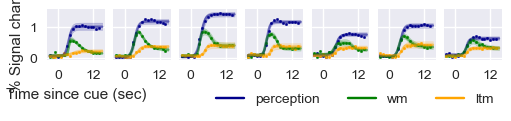

In [6]:
log_params = log_params.query("component == 'denoiseddata'")
start, stop = 0, -2
t = np.linspace(vmfits.timepoint.unique()[0], vmfits.timepoint.unique()[-2], 10000)
           
fig, axs = plt.subplots(1, 7, sharex = True, sharey = True, figsize = [fig_width, fig_height/5], layout = 'constrained')

for i, row in log_params.iterrows():

    match row.task:
        case 'wm':
            params = [row.l, row.k, row.x0, row.c, row.k2, row.x2, row.c2]
            y = logistic2(t, *params)
        case 'perception' | 'ltm':
            params = [row.l, row.k, row.x0, row.c]
            y = logistic(t, *params)

    c = rois.index(row.roi)

    ax = axs[c]

    vmf = vmfits.query("roi_labels == @row.roi & task == @row.task & component == 'denoiseddata'")
    x_scatter = vmf.timepoint[start:stop]
    y_scatter = vmf.amp[start:stop]

    err_bands = EB["%s_%s" % (row.roi, row.task)]
    ax.fill_between(x = t,  y1 = err_bands[1, :], y2 = err_bands[0, :], color = task_cmap[row.task], alpha = 0.2)
    ax.scatter(x = x_scatter, y = y_scatter, color = task_cmap[row.task], s = 3)
    ax.plot(t, y, color = task_cmap[row.task], alpha = 0.5)
    ax.set_xticks([0, 12], [0, 12])



    sns.stripplot()


axs[0].set_xlabel("Time since cue (sec)")
axs[0].set_ylabel("% Signal change")


for task in tasks:
    plt.plot([], label = "%s" % (task), color = task_cmap[task])

fig.legend(loc = 'upper right', bbox_to_anchor = (1, 0.25), bbox_transform = fig.transFigure, ncol = 3)

plt.savefig(os.path.join("fig_images", "fig6B.pdf") , transparent = False)




# Figure 6c

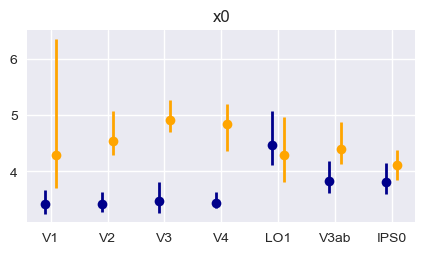

In [7]:
log_metrics = ['x0']

data_df = []
for roi, task, metric in itertools.product(rois, tasks, log_metrics):
    data = boots.query("task == @task & roi == @roi")

    m = [i for i in data[metric] if i != np.nan]
    CIs = np.nanquantile(m, [0.16, 0.84, 0.025, 0.975])
    metric_val = log_params.query("task == @task & roi == @roi")[metric].values[0]

    row = [roi, task, metric, metric_val, *CIs]
    data_df.append(row)

data_df = pd.DataFrame(data_df, columns = ['roi_labels', "task", "metric", "value", "lower_68_CI", "upper_68_CI", "lower_95_CI", "upper_95_CI"])

data_df['roi'] = pd.Categorical(data_df['roi_labels'], categories = rois , ordered = True)


fig, axs = plt.subplots(1, figsize = [fig_width, fig_height/2])
for task, lm in itertools.product(['perception', 'ltm'], log_metrics):

    b = data_df.query("metric == @lm & task == @task")
    xerr = [b.value.values - b.lower_68_CI.values, b.upper_68_CI.values - b.value.values]
    xerr = np.asarray(xerr)

    offset = tasks.index(task) * -.1
    x = [rois.index(label)+1 - offset for label in b.roi_labels]

    axs.errorbar(x, b.value, yerr = xerr, fmt = "o", color = task_cmap[task], alpha = 1, elinewidth = 2)
    axs.set_title(lm)
    axs.set_xticks(np.arange(1, 8)+.1, rois)


plt.savefig(os.path.join("fig_images", "fig6C.pdf") , transparent = False)


# Figure 6d

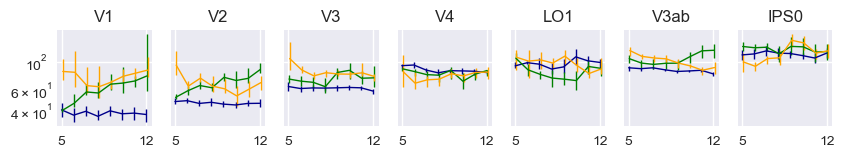

In [8]:
wm_t_peak_amp = {}

for roi in rois:
    wm_t_peak_amp[roi] = np.argmax(vmfits.query("roi_labels == @roi & task == 'wm' & component == 'denoiseddata'").amp.values)


fig, axs = plt.subplots(1, 7, sharex = True, sharey = True, figsize = [fig_width*2, fig_height/4])
start, stop = 8, 16

fwhm_DF = []
for roi, task in itertools.product(rois, tasks):
    x = np.arange(start-3, stop-3) + 0.05*tasks.index(task)
    y = vmfits.query("roi_labels == @roi & task == @task & component == 'denoiseddata'").fwhm.values

    b_lower = boots.query("roi == @roi & task == @task").quantile([0.16], numeric_only = True).filter(like = 'fwhm').values[0,:]
    b_upper = boots.query("roi == @roi & task == @task").quantile([0.84], numeric_only = True).filter(like = 'fwhm').values[0,:]

    wm_t = wm_t_peak_amp[roi]
    
    b_peak = boots.query("roi == @roi & task == @task")['fwhm_t%02d' % wm_t]
    b_off = boots.query("roi == @roi & task == @task")['fwhm_t%02d' % 15]
    b_diff = b_off.values - b_peak.values
    b_diff_lower95, b_diff_upper95 = np.nanquantile(b_diff, [0.025, 0.975])
    b_diff_lower68, b_diff_upper68 = np.nanquantile(b_diff, [0.16, 0.84])

    fwhm_peak = np.round(y[wm_t], 1)
    fwhm_off = np.round(y[15], 1)
    fwhm_diff = fwhm_off - fwhm_peak

    row = [roi, task, wm_t-3, fwhm_peak, fwhm_off, fwhm_diff, np.round(b_diff_lower68, 1), np.round(b_diff_upper68, 1), np.round(b_diff_lower95, 1), np.round(b_diff_upper95, 1)]
    fwhm_DF.append(row)

    y = y[start:stop]
    b_lower = b_lower[start:stop]
    b_upper = b_upper[start:stop]
    
    ax = axs[rois.index(roi)]
    ax.set_title(roi)

    ax.errorbar(x, y, yerr = [y - b_lower, b_upper - y], color = task_cmap[task], linewidth = 1)
    ax.set_xticks([5, 12])
    ax.set_yscale('log')

fwhm_DF = pd.DataFrame(fwhm_DF, columns = ['roi', 'task', 'wm_t_peak_amp', 'fwhm_peak', 'fwhm_off', 'fwhm_diff', 'fwhm_diff_lower68', 'fwhm_diff_upper68', 'fwhm_diff_lower95', 'fwhm_diff_upper95'])

plt.savefig(os.path.join("fig_images", "fig6D.pdf") , transparent = False)

